In [12]:
import pandas as pd

ges1 = pd.read_csv("ges.csv")
ges1.head()

,Unnamed: 0,UID No,GSDB No,Manufacturer,Engine Identification,Combustor Description,Eng Type,B/P Ratio,Pressure Ratio,Rated Thrust (kN),...,Final Test Date,Compliance with fuel venting requirements,Remark 1,Remark 2,Remark 3,Remark 4,Remark 5,Remark 6,Remark 7,Remark 8
0,0,1AS001,1,Allied Signal,TFE731-2-2B,NaN,TF,2.64,13.90,15.60,...,1976-04-01,NaN,Not required to meet GASEOUS regulations,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1AS002,1,Allied Signal,TFE731-3,NaN,TF,2.64,14.30,16.50,...,1976-08-01,NaN,Not required to meet GASEOUS regulations,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,4AL003,4,Rolls-Royce Corporation,AE3007A,NaN,MTF,5.23,18.08,33.73,...,1995-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,6AL004,6,Rolls-Royce Corporation,AE3007C1,NaN,MTF,5.10,16.60,31.50,...,1995-04-19,NaN,Results based on Rolls Royce report EDR 15171B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,6AL005,6,Rolls-Royce Corporation,AE3007A1,Type 1,MTF,4.77,17.97,34.91,...,1995-04-19,NaN,For effectivity see Rolls-Royce Notice to Oper...,Results are based on Rolls-Royce report EDR 15...,AE3007A1 data in this report replace data repo...,NaN,NaN,NaN,NaN,NaN


In [13]:
ges1['HC LTO Total mass (g)']

0      823.0
1      393.0
2      226.0
3      346.0
4      307.0
       ...  
810    337.0
811      NaN
812      NaN
813      NaN
814      NaN
Name: HC LTO Total mass (g), Length: 815, dtype: float64

Mean Imputation

R-squared score: 0.23231682380107865
RMSE: 3166.615070945612


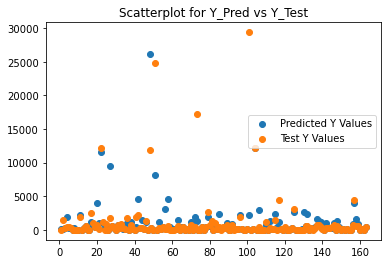

In [14]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings(action='ignore')              # Turn off the warnings.
# %matplotlib inline


# Step 2: Import Dataset
ges1 = pd.read_csv("ges.csv")

ges1.rename(columns={"Fuel LTO Cycle (kg)  ":"Fuel LTO Cycle (kg)"}, inplace=True)
shapeGes1 = ges1.shape

gesHC = ges1[['Eng Type','B/P Ratio', 'Fuel LTO Cycle (kg)','HC LTO Total mass (g)']]
gesHC.to_excel('gesHC_test.xlsx')

gesTest3 = gesHC
# print('NaN Count =', gesTest3.isna().sum().sum())


### Option 4: Mean Imputation
gesHC['B/P Ratio'].fillna(gesHC['B/P Ratio'].mean(), inplace=True)
gesHC['Fuel LTO Cycle (kg)'].fillna(gesHC['Fuel LTO Cycle (kg)'].mean(), inplace=True)
gesHC['HC LTO Total mass (g)'].fillna(gesHC['HC LTO Total mass (g)'].mean(), inplace=True)

# 3 independent variables (x values)
#dummy encoding for engine type
gesHC1 = pd.get_dummies(gesHC, columns=['Eng Type'])
BpHC = gesHC1['B/P Ratio']
FuelLto = gesHC1['Fuel LTO Cycle (kg)']

#dependent variable (y values)
LtoMassHC = gesHC1['HC LTO Total mass (g)']

desc = gesHC1.describe(include='all').T

### Choose either TF or MTF:


## Select rows based on condition: MTF
gesHC2 = gesHC1[(gesHC1['Eng Type_MTF'] == 1)]
## Drop the Eng Type_TF column from df
gesHC2 = gesHC2.drop(['Eng Type_TF'],axis=1).values


####### Outlier Treament Applied: IQR Method

## Detecting outliers using the Inter Quantile Range(IQR)
## (1) Doing this for LTO Mass for HC
LtoMassHC2 = gesHC2[:,2]
outliers = []
def detect_outliers_iqr(LtoMassHC2):
    LtoMassHC2 = sorted(LtoMassHC2)
    q1 = np.percentile(LtoMassHC2, 25)
    q3 = np.percentile(LtoMassHC2, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in LtoMassHC2: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code
HCMass_outliers = detect_outliers_iqr(LtoMassHC2)
# print("Mass HC Outliers from IQR method: ", HCMass_outliers)


## Version 2: Quantile Based Flooring & Capping for Mass NOx
ten_per = np.percentile(LtoMassHC2,10)
ninety_per = np.percentile(LtoMassHC2,90)
gesHC3 = np.where(gesHC2>ninety_per, ninety_per, gesHC2)


## Detecting outliers using the Inter Quantile Range(IQR)
## (2) Doing this for B/P Ratio for NOx
BpHC2 = gesHC3[:,0]
outliers2 = []
def detect_outliers_iqr(BpHC2):
    BpHC2 = sorted(BpHC2)
    q1_2 = np.percentile(BpHC2, 25)
    q3_2 = np.percentile(BpHC2, 75)
    # print(q1, q3)
    IQR2 = q3_2-q1_2
    lwr_bound_2 = q1_2-(1.5*IQR2)
    upr_bound_2 = q3_2+(1.5*IQR2)
    # print(lwr_bound, upr_bound)
    for i in BpHC2: 
        if (i<lwr_bound_2 or i>upr_bound_2):
            outliers2.append(i)
    return outliers2 # Driver code
BpHC2_outliers = detect_outliers_iqr(BpHC2)
# print("B/P Ratio Outliers from IQR method: ", BpHC2_outliers)


## Version 2: Quantile Based Flooring & Capping for B/P Ratio
ten_per2 = np.percentile(BpHC2,10)
ninety_per2 = np.percentile(BpHC2,90)
gesHC4 = np.where(gesHC3>ninety_per, ninety_per, gesHC3)



## Detecting outliers using the Inter Quantile Range(IQR)
## (2) Doing this for Fuel LTO Cycle for NOx
FuelLto3 = gesHC3[:,1]
outliers3 = []
def detect_outliers_iqr(FuelLto3):
    FuelLto3 = sorted(FuelLto3)
    q1_3 = np.percentile(FuelLto3, 25)
    q3_3 = np.percentile(FuelLto3, 75)
    # print(q1, q3)
    IQR3 = q3_3-q1_3
    lwr_bound_3 = q1_3-(1.5*IQR3)
    upr_bound_3 = q3_3+(1.5*IQR3)
    # print(lwr_bound, upr_bound)
    for i in FuelLto3: 
        if (i<lwr_bound_3 or i>upr_bound_3):
            outliers3.append(i)
    return outliers3 # Driver code
FuelLto3_outliers = detect_outliers_iqr(FuelLto3)
# print("Fuel LTO Cycle Outliers from IQR method: ", FuelLto3_outliers)


## Version 2: Quantile Based Flooring & Capping for B/P Ratio
ten_per3 = np.percentile(FuelLto3,10)
ninety_per3 = np.percentile(FuelLto3,90)
gesHC5 = np.where(gesHC4>ninety_per, ninety_per, gesHC4)


### Step 3: Define x and y (w/ Outlier Treatment)
# #get x and y values
gesHC6 = np.delete(gesHC5,2,axis=1)
x = gesHC6
y = gesHC5[:,2]


# Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(gesHC1.drop(columns=['HC LTO Total mass (g)']), 
                                                    gesHC1['HC LTO Total mass (g)'], 
                                                    test_size=0.2, 
                                                    random_state=0)

# Creating the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Predicting the values for test set
y_pred = rf_model.predict(X_test)
lenY = len(y_pred)

# Checking the performance of the model
print('R-squared score:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

# Scatterplot
list2 = np.linspace(1,lenY,lenY)
plt.scatter(list2,y_pred,label='Predicted Y Values')
plt.scatter(list2,y_test,label='Test Y Values')

# Label Plot
plt.title('Scatterplot for Y_Pred vs Y_Test')
plt.legend()
plt.show()


Median Imputation

R-squared score: 0.20270119148976906
RMSE: 3227.1178114650756


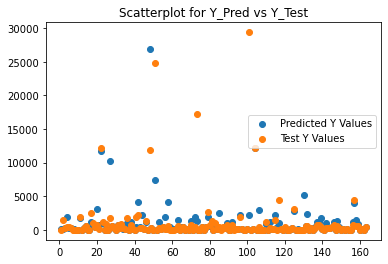

In [15]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings(action='ignore')              # Turn off the warnings.
# %matplotlib inline


# Step 2: Import Dataset
ges1 = pd.read_csv("ges.csv")

ges1.rename(columns={"Fuel LTO Cycle (kg)  ":"Fuel LTO Cycle (kg)"}, inplace=True)
shapeGes1 = ges1.shape

gesHC = ges1[['Eng Type','B/P Ratio', 'Fuel LTO Cycle (kg)','HC LTO Total mass (g)']]
gesHC.to_excel('gesHC_test.xlsx')

gesTest3 = gesHC
# print('NaN Count =', gesTest3.isna().sum().sum())


### Option 4: Mean Imputation
gesHC['B/P Ratio'].fillna(gesHC['B/P Ratio'].median(), inplace=True)
gesHC['Fuel LTO Cycle (kg)'].fillna(gesHC['Fuel LTO Cycle (kg)'].median(), inplace=True)
gesHC['HC LTO Total mass (g)'].fillna(gesHC['HC LTO Total mass (g)'].median(), inplace=True)

# 3 independent variables (x values)
#dummy encoding for engine type
gesHC1 = pd.get_dummies(gesHC, columns=['Eng Type'])
BpHC = gesHC1['B/P Ratio']
FuelLto = gesHC1['Fuel LTO Cycle (kg)']

#dependent variable (y values)
LtoMassHC = gesHC1['HC LTO Total mass (g)']

desc = gesHC1.describe(include='all').T

### Choose either TF or MTF:


## Select rows based on condition: MTF
gesHC2 = gesHC1[(gesHC1['Eng Type_MTF'] == 1)]
## Drop the Eng Type_TF column from df
gesHC2 = gesHC2.drop(['Eng Type_TF'],axis=1).values


####### Outlier Treament Applied: IQR Method

## Detecting outliers using the Inter Quantile Range(IQR)
## (1) Doing this for LTO Mass for HC
LtoMassHC2 = gesHC2[:,2]
outliers = []
def detect_outliers_iqr(LtoMassHC2):
    LtoMassHC2 = sorted(LtoMassHC2)
    q1 = np.percentile(LtoMassHC2, 25)
    q3 = np.percentile(LtoMassHC2, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in LtoMassHC2: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code
HCMass_outliers = detect_outliers_iqr(LtoMassHC2)
# print("Mass HC Outliers from IQR method: ", HCMass_outliers)


## Version 2: Quantile Based Flooring & Capping for Mass NOx
ten_per = np.percentile(LtoMassHC2,10)
ninety_per = np.percentile(LtoMassHC2,90)
gesHC3 = np.where(gesHC2>ninety_per, ninety_per, gesHC2)


## Detecting outliers using the Inter Quantile Range(IQR)
## (2) Doing this for B/P Ratio for NOx
BpHC2 = gesHC3[:,0]
outliers2 = []
def detect_outliers_iqr(BpHC2):
    BpHC2 = sorted(BpHC2)
    q1_2 = np.percentile(BpHC2, 25)
    q3_2 = np.percentile(BpHC2, 75)
    # print(q1, q3)
    IQR2 = q3_2-q1_2
    lwr_bound_2 = q1_2-(1.5*IQR2)
    upr_bound_2 = q3_2+(1.5*IQR2)
    # print(lwr_bound, upr_bound)
    for i in BpHC2: 
        if (i<lwr_bound_2 or i>upr_bound_2):
            outliers2.append(i)
    return outliers2 # Driver code
BpHC2_outliers = detect_outliers_iqr(BpHC2)
# print("B/P Ratio Outliers from IQR method: ", BpHC2_outliers)


## Version 2: Quantile Based Flooring & Capping for B/P Ratio
ten_per2 = np.percentile(BpHC2,10)
ninety_per2 = np.percentile(BpHC2,90)
gesHC4 = np.where(gesHC3>ninety_per, ninety_per, gesHC3)



## Detecting outliers using the Inter Quantile Range(IQR)
## (2) Doing this for Fuel LTO Cycle for NOx
FuelLto3 = gesHC3[:,1]
outliers3 = []
def detect_outliers_iqr(FuelLto3):
    FuelLto3 = sorted(FuelLto3)
    q1_3 = np.percentile(FuelLto3, 25)
    q3_3 = np.percentile(FuelLto3, 75)
    # print(q1, q3)
    IQR3 = q3_3-q1_3
    lwr_bound_3 = q1_3-(1.5*IQR3)
    upr_bound_3 = q3_3+(1.5*IQR3)
    # print(lwr_bound, upr_bound)
    for i in FuelLto3: 
        if (i<lwr_bound_3 or i>upr_bound_3):
            outliers3.append(i)
    return outliers3 # Driver code
FuelLto3_outliers = detect_outliers_iqr(FuelLto3)
# print("Fuel LTO Cycle Outliers from IQR method: ", FuelLto3_outliers)


## Version 2: Quantile Based Flooring & Capping for B/P Ratio
ten_per3 = np.percentile(FuelLto3,10)
ninety_per3 = np.percentile(FuelLto3,90)
gesHC5 = np.where(gesHC4>ninety_per, ninety_per, gesHC4)


### Step 3: Define x and y (w/ Outlier Treatment)
# #get x and y values
gesHC6 = np.delete(gesHC5,2,axis=1)
x = gesHC6
y = gesHC5[:,2]


# Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(gesHC1.drop(columns=['HC LTO Total mass (g)']), 
                                                    gesHC1['HC LTO Total mass (g)'], 
                                                    test_size=0.2, 
                                                    random_state=0)

# Creating the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Predicting the values for test set
y_pred = rf_model.predict(X_test)
lenY = len(y_pred)

# Checking the performance of the model
print('R-squared score:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

# Scatterplot
list2 = np.linspace(1,lenY,lenY)
plt.scatter(list2,y_pred,label='Predicted Y Values')
plt.scatter(list2,y_test,label='Test Y Values')

# Label Plot
plt.title('Scatterplot for Y_Pred vs Y_Test')
plt.legend()
plt.show()


NaN replaced by 0

R-squared score: 0.1516172471766637
RMSE: 3328.8956242257395


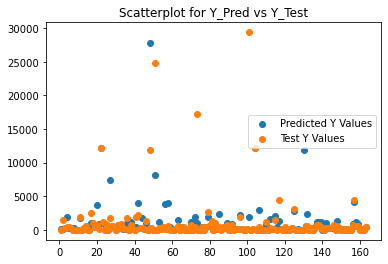

In [16]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings(action='ignore')              # Turn off the warnings.
# %matplotlib inline


# Step 2: Import Dataset
ges1 = pd.read_csv("ges.csv")

ges1.rename(columns={"Fuel LTO Cycle (kg)  ":"Fuel LTO Cycle (kg)"}, inplace=True)
shapeGes1 = ges1.shape

gesHC = ges1[['Eng Type','B/P Ratio', 'Fuel LTO Cycle (kg)','HC LTO Total mass (g)']]
gesHC.to_excel('gesHC_test.xlsx')

gesTest3 = gesHC
# print('NaN Count =', gesTest3.isna().sum().sum())


### Option 4: Mean Imputation
gesHC = gesHC.fillna(0)

# 3 independent variables (x values)
#dummy encoding for engine type
gesHC1 = pd.get_dummies(gesHC, columns=['Eng Type'])
BpHC = gesHC1['B/P Ratio']
FuelLto = gesHC1['Fuel LTO Cycle (kg)']

#dependent variable (y values)
LtoMassHC = gesHC1['HC LTO Total mass (g)']

desc = gesHC1.describe(include='all').T

### Choose either TF or MTF:


## Select rows based on condition: MTF
gesHC2 = gesHC1[(gesHC1['Eng Type_MTF'] == 1)]
## Drop the Eng Type_TF column from df
gesHC2 = gesHC2.drop(['Eng Type_TF'],axis=1).values


####### Outlier Treament Applied: IQR Method

## Detecting outliers using the Inter Quantile Range(IQR)
## (1) Doing this for LTO Mass for HC
LtoMassHC2 = gesHC2[:,2]
outliers = []
def detect_outliers_iqr(LtoMassHC2):
    LtoMassHC2 = sorted(LtoMassHC2)
    q1 = np.percentile(LtoMassHC2, 25)
    q3 = np.percentile(LtoMassHC2, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in LtoMassHC2: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code
HCMass_outliers = detect_outliers_iqr(LtoMassHC2)
# print("Mass HC Outliers from IQR method: ", HCMass_outliers)


## Version 2: Quantile Based Flooring & Capping for Mass NOx
ten_per = np.percentile(LtoMassHC2,10)
ninety_per = np.percentile(LtoMassHC2,90)
gesHC3 = np.where(gesHC2>ninety_per, ninety_per, gesHC2)


## Detecting outliers using the Inter Quantile Range(IQR)
## (2) Doing this for B/P Ratio for NOx
BpHC2 = gesHC3[:,0]
outliers2 = []
def detect_outliers_iqr(BpHC2):
    BpHC2 = sorted(BpHC2)
    q1_2 = np.percentile(BpHC2, 25)
    q3_2 = np.percentile(BpHC2, 75)
    # print(q1, q3)
    IQR2 = q3_2-q1_2
    lwr_bound_2 = q1_2-(1.5*IQR2)
    upr_bound_2 = q3_2+(1.5*IQR2)
    # print(lwr_bound, upr_bound)
    for i in BpHC2: 
        if (i<lwr_bound_2 or i>upr_bound_2):
            outliers2.append(i)
    return outliers2 # Driver code
BpHC2_outliers = detect_outliers_iqr(BpHC2)
# print("B/P Ratio Outliers from IQR method: ", BpHC2_outliers)


## Version 2: Quantile Based Flooring & Capping for B/P Ratio
ten_per2 = np.percentile(BpHC2,10)
ninety_per2 = np.percentile(BpHC2,90)
gesHC4 = np.where(gesHC3>ninety_per, ninety_per, gesHC3)



## Detecting outliers using the Inter Quantile Range(IQR)
## (2) Doing this for Fuel LTO Cycle for NOx
FuelLto3 = gesHC3[:,1]
outliers3 = []
def detect_outliers_iqr(FuelLto3):
    FuelLto3 = sorted(FuelLto3)
    q1_3 = np.percentile(FuelLto3, 25)
    q3_3 = np.percentile(FuelLto3, 75)
    # print(q1, q3)
    IQR3 = q3_3-q1_3
    lwr_bound_3 = q1_3-(1.5*IQR3)
    upr_bound_3 = q3_3+(1.5*IQR3)
    # print(lwr_bound, upr_bound)
    for i in FuelLto3: 
        if (i<lwr_bound_3 or i>upr_bound_3):
            outliers3.append(i)
    return outliers3 # Driver code
FuelLto3_outliers = detect_outliers_iqr(FuelLto3)
# print("Fuel LTO Cycle Outliers from IQR method: ", FuelLto3_outliers)


## Version 2: Quantile Based Flooring & Capping for B/P Ratio
ten_per3 = np.percentile(FuelLto3,10)
ninety_per3 = np.percentile(FuelLto3,90)
gesHC5 = np.where(gesHC4>ninety_per, ninety_per, gesHC4)


### Step 3: Define x and y (w/ Outlier Treatment)
# #get x and y values
gesHC6 = np.delete(gesHC5,2,axis=1)
x = gesHC6
y = gesHC5[:,2]


# Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(gesHC1.drop(columns=['HC LTO Total mass (g)']), 
                                                    gesHC1['HC LTO Total mass (g)'], 
                                                    test_size=0.2, 
                                                    random_state=0)

# Creating the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Predicting the values for test set
y_pred = rf_model.predict(X_test)
lenY = len(y_pred)

# Checking the performance of the model
print('R-squared score:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

# Scatterplot
list2 = np.linspace(1,lenY,lenY)
plt.scatter(list2,y_pred,label='Predicted Y Values')
plt.scatter(list2,y_test,label='Test Y Values')

# Label Plot
plt.title('Scatterplot for Y_Pred vs Y_Test')
plt.legend()
plt.show()


NaN Deleted

R-squared score: 0.3931418791992741
RMSE: 2410.4876579526563


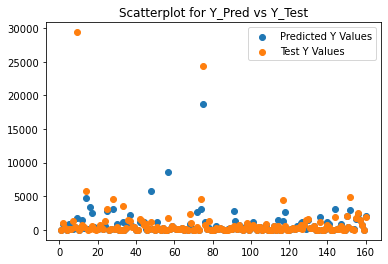

In [17]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings(action='ignore')              # Turn off the warnings.
# %matplotlib inline


# Step 2: Import Dataset
ges1 = pd.read_csv("ges.csv")

ges1.rename(columns={"Fuel LTO Cycle (kg)  ":"Fuel LTO Cycle (kg)"}, inplace=True)
shapeGes1 = ges1.shape

gesHC = ges1[['Eng Type','B/P Ratio', 'Fuel LTO Cycle (kg)','HC LTO Total mass (g)']]
gesHC.to_excel('gesHC_test.xlsx')

gesTest3 = gesHC
# print('NaN Count =', gesTest3.isna().sum().sum())


### Option 4: Mean Imputation
gesHC = gesHC.dropna()

# 3 independent variables (x values)
#dummy encoding for engine type
gesHC1 = pd.get_dummies(gesHC, columns=['Eng Type'])
BpHC = gesHC1['B/P Ratio']
FuelLto = gesHC1['Fuel LTO Cycle (kg)']

#dependent variable (y values)
LtoMassHC = gesHC1['HC LTO Total mass (g)']

desc = gesHC1.describe(include='all').T

### Choose either TF or MTF:


## Select rows based on condition: MTF
gesHC2 = gesHC1[(gesHC1['Eng Type_TF'] == 1)]
## Drop the Eng Type_TF column from df
gesHC2 = gesHC2.drop(['Eng Type_MTF'],axis=1).values


####### Outlier Treament Applied: IQR Method

## Detecting outliers using the Inter Quantile Range(IQR)
## (1) Doing this for LTO Mass for HC
LtoMassHC2 = gesHC2[:,2]
outliers = []
def detect_outliers_iqr(LtoMassHC2):
    LtoMassHC2 = sorted(LtoMassHC2)
    q1 = np.percentile(LtoMassHC2, 25)
    q3 = np.percentile(LtoMassHC2, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in LtoMassHC2: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers# Driver code
HCMass_outliers = detect_outliers_iqr(LtoMassHC2)
# print("Mass HC Outliers from IQR method: ", HCMass_outliers)


## Version 2: Quantile Based Flooring & Capping for Mass NOx
ten_per = np.percentile(LtoMassHC2,10)
ninety_per = np.percentile(LtoMassHC2,90)
gesHC3 = np.where(gesHC2>ninety_per, ninety_per, gesHC2)


## Detecting outliers using the Inter Quantile Range(IQR)
## (2) Doing this for B/P Ratio for NOx
BpHC2 = gesHC3[:,0]
outliers2 = []
def detect_outliers_iqr(BpHC2):
    BpHC2 = sorted(BpHC2)
    q1_2 = np.percentile(BpHC2, 25)
    q3_2 = np.percentile(BpHC2, 75)
    # print(q1, q3)
    IQR2 = q3_2-q1_2
    lwr_bound_2 = q1_2-(1.5*IQR2)
    upr_bound_2 = q3_2+(1.5*IQR2)
    # print(lwr_bound, upr_bound)
    for i in BpHC2: 
        if (i<lwr_bound_2 or i>upr_bound_2):
            outliers2.append(i)
    return outliers2 # Driver code
BpHC2_outliers = detect_outliers_iqr(BpHC2)
# print("B/P Ratio Outliers from IQR method: ", BpHC2_outliers)


## Version 2: Quantile Based Flooring & Capping for B/P Ratio
ten_per2 = np.percentile(BpHC2,10)
ninety_per2 = np.percentile(BpHC2,90)
gesHC4 = np.where(gesHC3>ninety_per, ninety_per, gesHC3)



## Detecting outliers using the Inter Quantile Range(IQR)
## (2) Doing this for Fuel LTO Cycle for NOx
FuelLto3 = gesHC3[:,1]
outliers3 = []
def detect_outliers_iqr(FuelLto3):
    FuelLto3 = sorted(FuelLto3)
    q1_3 = np.percentile(FuelLto3, 25)
    q3_3 = np.percentile(FuelLto3, 75)
    # print(q1, q3)
    IQR3 = q3_3-q1_3
    lwr_bound_3 = q1_3-(1.5*IQR3)
    upr_bound_3 = q3_3+(1.5*IQR3)
    # print(lwr_bound, upr_bound)
    for i in FuelLto3: 
        if (i<lwr_bound_3 or i>upr_bound_3):
            outliers3.append(i)
    return outliers3 # Driver code
FuelLto3_outliers = detect_outliers_iqr(FuelLto3)
# print("Fuel LTO Cycle Outliers from IQR method: ", FuelLto3_outliers)


## Version 2: Quantile Based Flooring & Capping for B/P Ratio
ten_per3 = np.percentile(FuelLto3,10)
ninety_per3 = np.percentile(FuelLto3,90)
gesHC5 = np.where(gesHC4>ninety_per, ninety_per, gesHC4)


### Step 3: Define x and y (w/ Outlier Treatment)
# #get x and y values
gesHC6 = np.delete(gesHC5,2,axis=1)
x = gesHC6
y = gesHC5[:,2]


# Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(gesHC1.drop(columns=['HC LTO Total mass (g)']), 
                                                    gesHC1['HC LTO Total mass (g)'], 
                                                    test_size=0.2, 
                                                    random_state=0)

# Creating the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Training the model
rf_model.fit(X_train, y_train)

# Predicting the values for test set
y_pred = rf_model.predict(X_test)
lenY = len(y_pred)

# Checking the performance of the model
print('R-squared score:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

# Scatterplot
list2 = np.linspace(1,lenY,lenY)
plt.scatter(list2,y_pred,label='Predicted Y Values')
plt.scatter(list2,y_test,label='Test Y Values')

# Label Plot
plt.title('Scatterplot for Y_Pred vs Y_Test')
plt.legend()
plt.show()
